<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/metrics/roc_balanced_unbalanced_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    roc_curve,
    roc_auc_score
)

# **Config**
---


In [35]:
warnings.filterwarnings('ignore')
sns.set(style='darkgrid')
title_data = 'Diabetes'
paleta = sns.color_palette('tab10').as_hex()
random_seed = 12354

# **Funciones**
---

In [36]:
def generate_colors(paleta:str="Set1", n_colors:int=15)-> tuple:
  """color generator"""
  try:
    cmap = sns.color_palette(paleta, n_colors).as_hex()
    list_camp = ListedColormap(cmap)
    return cmap, list_camp
  except Exception as e:
    print(e)


def plot_bar(data:pd.DataFrame, paleta:list=None, figsize_x:int=8, figsize_y:int=5,
             fontsize:int=15, **kwards)->None:
  """Grafica un diagrama de barras con multiples caracteristicas"""
  try:
    paleta = paleta if paleta !=None else generate_colors()[0]
    v = kwards
    ejeX = v["ejeX"]

    fig, ax = plt.subplots(figsize = (figsize_x, figsize_y))
    fig.suptitle(f'Diagrama de barras {v["title"]}', fontsize=fontsize)

    if type(ejeX) == str:
      sns.countplot(x=ejeX, data=data, ax = ax, palette=paleta)
    else:
      ejeX = v['ejeX'][0]
      sns.countplot(x=ejeX, hue=v['ejeX'][1], data=data, ax=ax, palette=paleta)

    ax.set_ylabel(v['ejey'], size = 12)
    ax.set_xlabel(ejeX, size=fontsize-3)

    ax.set_xticklabels(ax.get_xticklabels(), fontsize = fontsize-3)
    for p in ax.patches:
      try:
        height = int(p.get_height())
        height_text = height
        if kwards['p'] == True:
          percentage = round(height/data.shape[0], 5)
          height_text = f'{height} ({percentage})'
        ax.text(p.get_x()+p.get_width()/2., height + 1, height_text, ha="center")
      except Exception as e:
        print(e)

  except Exception as e:
    print(e)

# **Generar Data ROC Balanced Data**
---

In [37]:
X, y = make_classification(
    n_samples = 1000,
    n_classes = 2,
    n_features = 8,
    n_redundant = 1,
    random_state=random_seed
    )

In [38]:
data = pd.DataFrame(X, columns=[f"c{i}" for i in range(8)])
data['c5'] = y

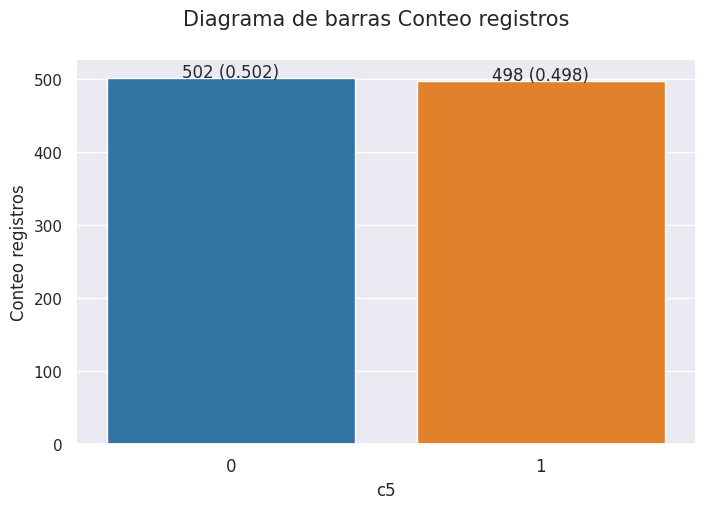

In [39]:
plot_bar(
    data,
    paleta=paleta,
    ejeX='c5',
    ejey='Conteo registros',
    title='Conteo registros', p=True)

## **Split**
---

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.5,
    random_state=random_seed
)

- **La data generada no requiere estandarizar**
- No se emplearan modelos tan complejos, ya que esto es un experimento

## **Model**
---

In [41]:
model = DecisionTreeClassifier(random_state=random_seed)

In [42]:
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': list(range(2, 8)),
    'min_samples_split': list(range(2, 8))
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    refit = True,
    return_train_score=True,
    cv=10,
)

In [43]:
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=12354),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 3, 4, 5, 6, 7],
                         'min_samples_split': [2, 3, 4, 5, 6, 7]},
             return_train_score=True)

In [44]:
print('Mejor: %f usando %s' % (grid.best_score_, grid.best_params_))

Mejor: 0.914000 usando {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 3}


In [45]:
model_tree = grid.best_estimator_
model_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 12354,
 'splitter': 'best'}

In [46]:
y_prob_tree = model_tree.predict_proba(X_test)
positive_case_prob_tree = y_prob_tree[:, 1]

# AUC
roc_auc_score_pc = roc_auc_score(y_test, positive_case_prob_tree)
print('DT: ROC AUC=%.3f' % (roc_auc_score_pc))

# ROC
fpr_tree, tpr_tree, umbrales = roc_curve(y_test, positive_case_prob_tree)

DT: ROC AUC=0.942


In [47]:
model_lg = LogisticRegression(solver='lbfgs')
model_lg.fit(X_train, y_train)

y_prob_lg  = model_lg.predict_proba(X_test)
positive_case_prob_lg = y_prob_lg[:, 1]

# AUC
roc_auc_score_lg = roc_auc_score(y_test, positive_case_prob_lg)
print('lg: ROC AUC=%.3f' % (roc_auc_score_lg))

# ROC
fpr_lg, tpr_lg, umbrales = roc_curve(y_test, positive_case_prob_lg)

lg: ROC AUC=0.950


In [48]:
y_prob_no_sklill = [0 for _ in range(len(y_test))]
roc_auc_score_no_skill = roc_auc_score(y_test, y_prob_no_sklill)
# AUC
print('No skill: ROC AUC=%.3f' % (roc_auc_score_no_skill))


# ROC
fpr_nkill, tpr_nkill, umbrales_nkill = roc_curve(y_test, y_prob_no_sklill)

No skill: ROC AUC=0.500


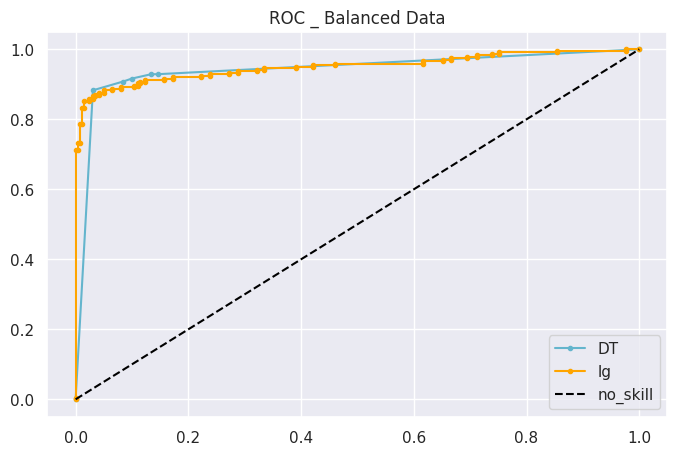

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
plt.plot(fpr_tree, tpr_tree, marker='.', label='DT', color = 'c')
plt.plot(fpr_lg, tpr_lg, marker='.', label='lg', color = 'orange')
plt.plot(fpr_nkill, tpr_nkill, linestyle='--', label='no_skill', color = 'black')
plt.title('ROC _ Balanced Data')
plt.legend()
plt.show()

# **Generar Data ROC Unbalanced Data**
---

In [50]:
X, y = make_classification(
    n_samples = 1000,
    n_classes = 2,
    n_features = 8,
    n_redundant = 1,
    weights=[0.99, 0.01],
    random_state=random_seed
    )

In [51]:
data = pd.DataFrame(X, columns=[f"c{i}" for i in range(8)])
data['c5'] = y

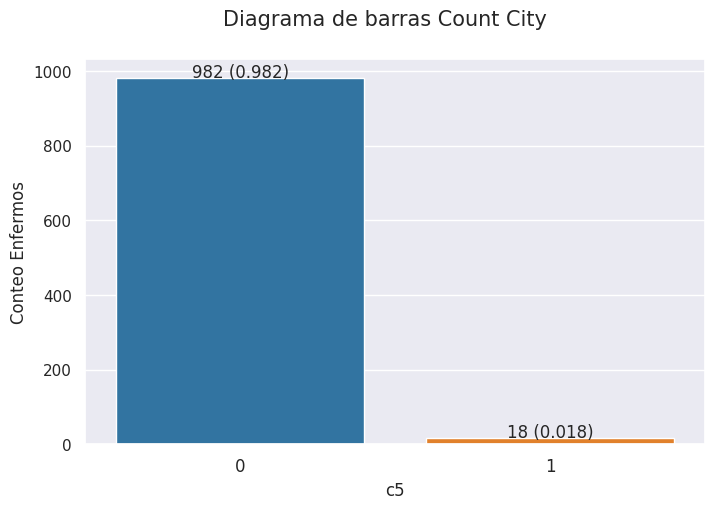

In [52]:
plot_bar(
    data,
    paleta=paleta,
    ejeX='c5',
    ejey='Conteo Enfermos',
    title='Count City', p=True)

## **Split**
---

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.7,
    random_state=random_seed
)

- **La data generada no requiere estandarizar**
- No se emplearan modelos tan complejos, ya que esto es un experimento

## **Model**
---

In [54]:
model = DecisionTreeClassifier(random_state=random_seed)

In [55]:
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': list(range(2, 8)),
    'min_samples_split': list(range(2, 8))
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    refit = True,
    return_train_score=True,
    cv=10,
)

In [56]:
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=12354),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 3, 4, 5, 6, 7],
                         'min_samples_split': [2, 3, 4, 5, 6, 7]},
             return_train_score=True)

In [57]:
print('Mejor: %f usando %s' % (grid.best_score_, grid.best_params_))

Mejor: 0.990000 usando {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 2}


In [58]:
model_tree = grid.best_estimator_
model_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 12354,
 'splitter': 'best'}

In [59]:
y_prob_tree = model_tree.predict_proba(X_test)
positive_case_prob_tree = y_prob_tree[:, 1]

# AUC
roc_auc_score_pc = roc_auc_score(y_test, positive_case_prob_tree)
print('DT: ROC AUC=%.3f' % (roc_auc_score_pc))

# ROC
fpr_tree, tpr_tree, umbrales = roc_curve(y_test, positive_case_prob_tree)

DT: ROC AUC=0.716


In [60]:
umbrales

array([2.        , 1.        , 0.07407407, 0.01433692, 0.        ])

In [61]:
model_lg = LogisticRegression(solver='lbfgs')
model_lg.fit(X_train, y_train)

y_prob_lg  = model_lg.predict_proba(X_test)
positive_case_prob_lg = y_prob_lg[:, 1]

# AUC
roc_auc_score_lg = roc_auc_score(y_test, positive_case_prob_lg)
print('lg: ROC AUC=%.3f' % (roc_auc_score_lg))

# ROC
fpr_lg, tpr_lg, umbrales = roc_curve(y_test, positive_case_prob_lg)

lg: ROC AUC=0.961


In [62]:
umbrales

array([1.51580286e+00, 5.15802859e-01, 1.85101420e-01, 5.48627022e-02,
       5.30706491e-02, 2.30458758e-02, 2.27893243e-02, 1.15035977e-04])

In [63]:
y_prob_no_sklill = [0 for _ in range(len(y_test))]
roc_auc_score_no_skill = roc_auc_score(y_test, y_prob_no_sklill)
# AUC
print('No skill: ROC AUC=%.3f' % (roc_auc_score_no_skill))


# ROC
fpr_nkill, tpr_nkill, umbrales_nkill = roc_curve(y_test, y_prob_no_sklill)

No skill: ROC AUC=0.500


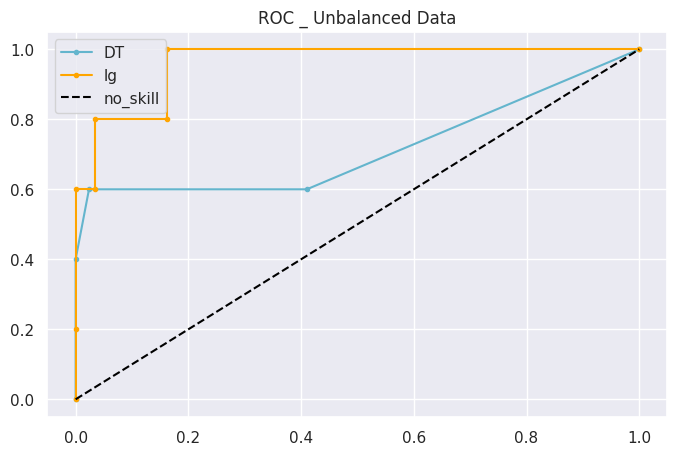

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
plt.plot(fpr_tree, tpr_tree, marker='.', label='DT', color = 'c')
plt.plot(fpr_lg, tpr_lg, marker='.', label='lg', color = 'orange')
plt.plot(fpr_nkill, tpr_nkill, linestyle='--', label='no_skill', color = 'black')
plt.title('ROC _ Unbalanced Data')
plt.legend()
plt.show()